In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
from scipy.ndimage import gaussian_filter1d

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(12)
#cluster = PBSCluster(cores=28, processes=14, walltime='02:30:00')
#w = cluster.scale(10*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.78:48864 Dashboard: http://10.148.1.78:8787/status,Cluster Workers: 12 Cores: 168 Memory: 720.00 GB


_________
# 1. Read dataset


In [8]:
out_dir_work = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA

In [9]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])

store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/'

In [10]:
# define gaussian filter 
def gaussianfilter(x, sigma, axis):
    
    return xr.apply_ufunc(gaussian_filter1d, x, sigma, axis,
                          dask='parallelized',
                          output_dtypes=[x.dtype])

# a test

In [ ]:
a_1 = gaussianfilter(ds.U.isel(depth=10), sigma=24/4, axis=0) # 1 day
a_7 = gaussianfilter(ds.U.isel(depth=10), sigma=24*7/4, axis=0) # 7 days
a_30 = gaussianfilter(ds.U.isel(depth=10), sigma=24*30/4, axis=0) # 30 days

(-0.6, 0.6)

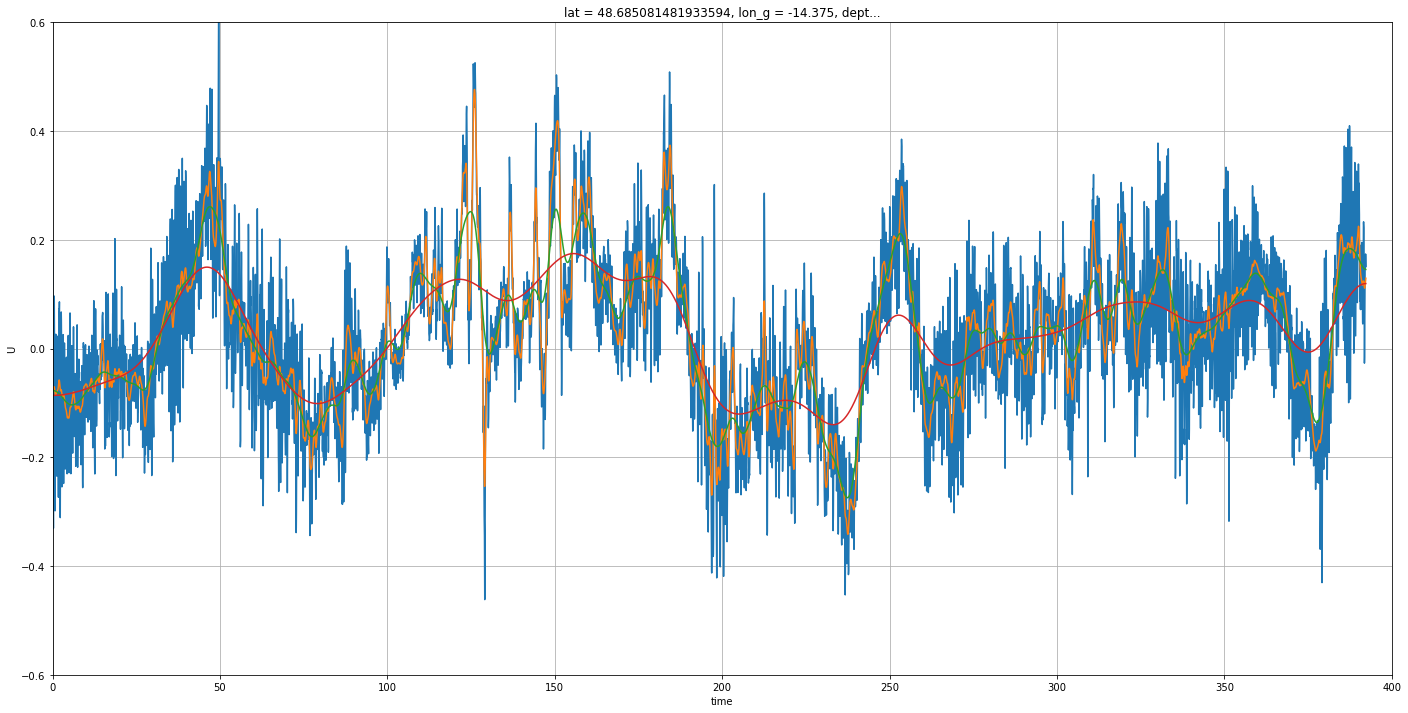

In [10]:
fig, ax = plt.subplots(figsize=(24,12))
ax = plt.subplot(111)

ds.U.isel(depth=10).sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()
a_1.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()
a_7.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()
a_30.sel(lat=48.6875,lon_g=343.8125,method='nearest').plot()

ax.grid()
ax.set_xlim([0,400])
ax.set_ylim([-.6, 0.6])

## save variables

In [18]:
du_dx = gridx.diff(ds.U, 'X')/gridx.interp(ds.dxG, 'Y')
du_dx = np.real(du_dx).rename('du_dx')     
du_dx = du_dx.to_dataset()
print(du_dx)
file_out = store_dir_zarr+'/du_dx.zarr'
du_dx.to_zarr(file_out, mode='w')                    

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    du_dx    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 176), meta=np.ndarray>


In [19]:
dv_dy = gridx.diff(ds.V, 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy = np.real(dv_dy).rename('dv_dy')     
dv_dy = dv_dy.to_dataset()
print(dv_dy)
file_out = store_dir_zarr+'/dv_dy.zarr'
dv_dy.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    dv_dy    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 200, 177), meta=np.ndarray>


In [9]:
du_dy = gridx.interp(gridx.interp(gridx.diff(ds.U, 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
du_dy = np.real(du_dy).rename('du_dy')     
du_dy = du_dy.to_dataset()
chunks = {'lat': 201, 'lon': 177, 'time':9415, 'depth':1}            
du_dy = du_dy.chunk(chunks)
print(du_dy)
file_out = store_dir_zarr+'/du_dy.zarr'
du_dy.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    du_dy    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


In [7]:
dv_dx = gridx.interp(gridx.interp(gridx.diff(ds.V, 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')
dv_dx = np.real(dv_dx).rename('dv_dx')     
dv_dx = dv_dx.to_dataset()
chunks = {'lat': 201, 'lon': 177, 'time':9415, 'depth':1}            
dv_dx = dv_dx.chunk(chunks)
print(dv_dx)
file_out = store_dir_zarr+'/dv_dx.zarr'
dv_dx.to_zarr(file_out, mode='w')   

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    dv_dx    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


In [22]:
u = gridx.interp(ds.U, 'X')
u = np.real(u).rename('u')     
u = u.to_dataset()
chunks = {'lat': 201, 'lon': 177, 'time':9415, 'depth':1}            
u = u.chunk(chunks)
print(u)
file_out = store_dir_zarr+'/u.zarr'
u.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


In [25]:
v = gridx.interp(ds.V, 'Y')
v = np.real(v).rename('v')     
v = v.to_dataset()
chunks = {'lat': 201, 'lon': 177, 'time':9415, 'depth':1}            
v = v.chunk(chunks)
print(v)
file_out = store_dir_zarr+'/v.zarr'
v.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    v        (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>


________

# At each depth

In [11]:
store_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/data/'

du_dx = xr.open_zarr(store_dir_zarr+'du_dx.zarr')
du_dy = xr.open_zarr(store_dir_zarr+'du_dy.zarr')
dv_dx = xr.open_zarr(store_dir_zarr+'dv_dx.zarr')
dv_dy = xr.open_zarr(store_dir_zarr+'dv_dy.zarr')

u = xr.open_zarr(store_dir_zarr+'u.zarr')
v = xr.open_zarr(store_dir_zarr+'v.zarr')

ds_cg = xr.merge([du_dx,du_dy,dv_dx,dv_dy,u,v])
print(ds_cg)
print('\n data size: %.1f GB' %(ds_cg.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    du_dx    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 176), meta=np.ndarray>
    du_dy    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>
    dv_dx    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>
    dv_dy    (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 200, 177), meta=np.ndarray>
    u        (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 201, 177), meta=np.ndarray>
    v        (time, depth, lat, lon) float32 dask.array<chunksize=

In [12]:
# define gaussian filter 
def gaussianfilter(x, sigma, axis):
    
    return xr.apply_ufunc(gaussian_filter1d, x, sigma, axis,
                          dask='parallelized',
                          output_dtypes=[x.dtype])

In [13]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/gaussian/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [ ]:
sigma = 30/4 # 30 hours ~ 1.3 days
VV = ['PI_cg_1d']

for depth in depth_all:
    
    for vv in VV:
        
        PI_1 = ( gaussianfilter(ds_cg.u.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.du_dx.isel(depth=depth), sigma=sigma, axis=0)
        PI_2 = ( gaussianfilter(ds_cg.v.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.dv_dy.isel(depth=depth), sigma=sigma, axis=0)
        PI_3 = ( gaussianfilter(ds_cg.u.isel(depth=depth)*ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0) * gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) ) * (gaussianfilter(ds_cg.du_dy.isel(depth=depth), sigma=sigma, axis=0)+gaussianfilter(ds_cg.dv_dx.isel(depth=depth), sigma=sigma, axis=0))
        PI_cg_single = -(PI_1+PI_2+PI_3)
        
        #PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = store_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

In [ ]:
sigma = 24*5/4 # 5 days
VV = ['PI_cg_5']

for depth in depth_all:
    
    for vv in VV:
        
        PI_1 = ( gaussianfilter(ds_cg.u.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.du_dx.isel(depth=depth), sigma=sigma, axis=0)
        PI_2 = ( gaussianfilter(ds_cg.v.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.dv_dy.isel(depth=depth), sigma=sigma, axis=0)
        PI_3 = ( gaussianfilter(ds_cg.u.isel(depth=depth)*ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0) * gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) ) * (gaussianfilter(ds_cg.du_dy.isel(depth=depth), sigma=sigma, axis=0)+gaussianfilter(ds_cg.dv_dx.isel(depth=depth), sigma=sigma, axis=0))
        PI_cg_single = -(PI_1+PI_2+PI_3)
        
        #PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = out_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

In [ ]:
sigma = 24*30/4 # 30 days
VV = ['PI_cg_30']

for depth in depth_all:
    
    for vv in VV:
        
        PI_1 = ( gaussianfilter(ds_cg.u.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.du_dx.isel(depth=depth), sigma=sigma, axis=0)
        PI_2 = ( gaussianfilter(ds_cg.v.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.dv_dy.isel(depth=depth), sigma=sigma, axis=0)
        PI_3 = ( gaussianfilter(ds_cg.u.isel(depth=depth)*ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0) * gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) ) * (gaussianfilter(ds_cg.du_dy.isel(depth=depth), sigma=sigma, axis=0)+gaussianfilter(ds_cg.dv_dx.isel(depth=depth), sigma=sigma, axis=0))
        PI_cg_single = -(PI_1+PI_2+PI_3)
        
        #PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        
        file_out = out_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed


In [ ]:
sigma = 24*90/4 # 90 days
VV = ['PI_cg_90']

for depth in depth_all:
    
    for vv in VV:
        
        PI_1 = ( gaussianfilter(ds_cg.u.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.du_dx.isel(depth=depth), sigma=sigma, axis=0)
        PI_2 = ( gaussianfilter(ds_cg.v.isel(depth=depth)**2, sigma=sigma, axis=0) - gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0)**2 ) * gaussianfilter(ds_cg.dv_dy.isel(depth=depth), sigma=sigma, axis=0)
        PI_3 = ( gaussianfilter(ds_cg.u.isel(depth=depth)*ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) - gaussianfilter(ds_cg.u.isel(depth=depth), sigma=sigma, axis=0) * gaussianfilter(ds_cg.v.isel(depth=depth), sigma=sigma, axis=0) ) * (gaussianfilter(ds_cg.du_dy.isel(depth=depth), sigma=sigma, axis=0)+gaussianfilter(ds_cg.dv_dx.isel(depth=depth), sigma=sigma, axis=0))
        PI_cg_single = -(PI_1+PI_2+PI_3)
        
        #PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()

        file_out = out_dir_zarr+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed


___________
# 1.3 -5 days 

In [6]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/gaussian/'

D = [xr.open_zarr(out_dir_store+'PI_cg_1_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_1d = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg_1d.PI_cg_single

D = [xr.open_zarr(out_dir_store+'PI_cg_5_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_single

In [7]:
PI_cg_1d = np.real(PI_cg_1d).rename('PI_cg_1d')
PI_cg_5d = np.real(PI_cg_5d).rename('PI_cg_5d')

In [13]:
PI_cg = PI_cg_5d-PI_cg_1d
PI_cg = np.real(PI_cg).rename('PI_cg')


chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)
PI_cg

<xarray.DataArray 'PI_cg' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<rechunk-merge, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [22]:
PI_cg

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
Data variables:
    PI_cg    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>

In [23]:
PI_cg = PI_cg_5d-PI_cg_1d
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.to_dataset()
PI_cg = PI_cg.chunk(chunks)
#del PI_cg['PI_cg'].encoding['chunks']
print(PI_cg)
file_out = out_dir_store+'PI_cg.zarr'
PI_cg.to_zarr(file_out, mode='w')                    

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
Data variables:
    PI_cg    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


In [7]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

ds = xr.merge([PI_cg_1d,PI_cg_5d,ds_MLD])
ds

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time        (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
Data variables:
    PI_cg_1d    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>
    PI_cg_5d    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

In [8]:
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
ds

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
Data variables:
    PI_cg_1d    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>
    PI_cg_5d    (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 201, 177), meta=np.ndarray>
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

In [28]:
winter = (ds.PI_cg_5d-ds.PI_cg_1d).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).sel(time=slice('2011-12-01T23:00:00','2012-03-01T23:00:00')).mean(['depth','time'])
spring = (ds.PI_cg_5d-ds.PI_cg_1d).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).sel(time=slice('2011-03-01T23:00:00','2012-06-01T23:00:00')).mean(['depth','time'])
winter

<xarray.DataArray (lat: 197, lon: 173)>
dask.array<mean_agg-aggregate, shape=(197, 173), dtype=float32, chunksize=(197, 173), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.43 47.44 47.46 47.47 ... 49.92 49.94 49.95 49.96
  * lon      (lon) float64 -17.99 -17.97 -17.95 -17.93 ... -14.45 -14.43 -14.41

In [29]:
winter.persist()
spring.persist()

<xarray.DataArray (lat: 197, lon: 173)>
dask.array<mean_agg-aggregate, shape=(197, 173), dtype=float32, chunksize=(197, 173), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.43 47.44 47.46 47.47 ... 49.92 49.94 49.95 49.96
  * lon      (lon) float64 -17.99 -17.97 -17.95 -17.93 ... -14.45 -14.43 -14.41

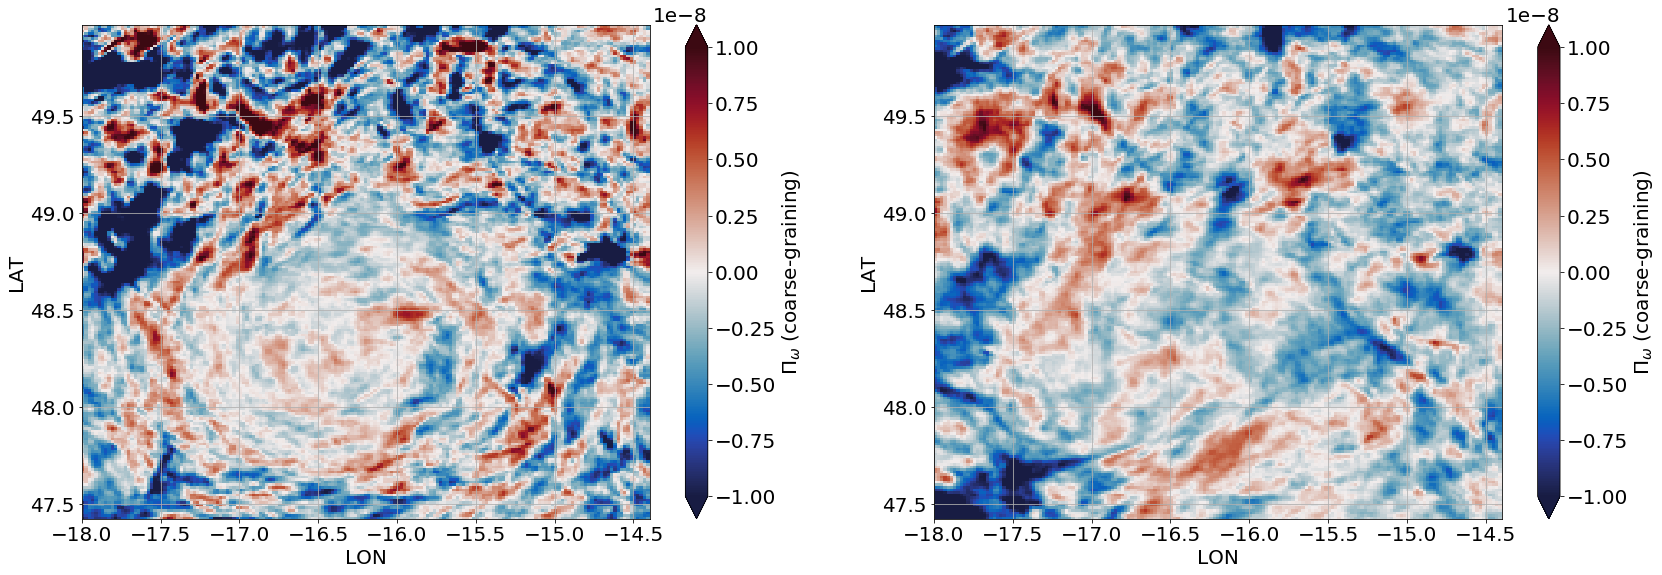

In [31]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = winter.plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
cax = spring.plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)


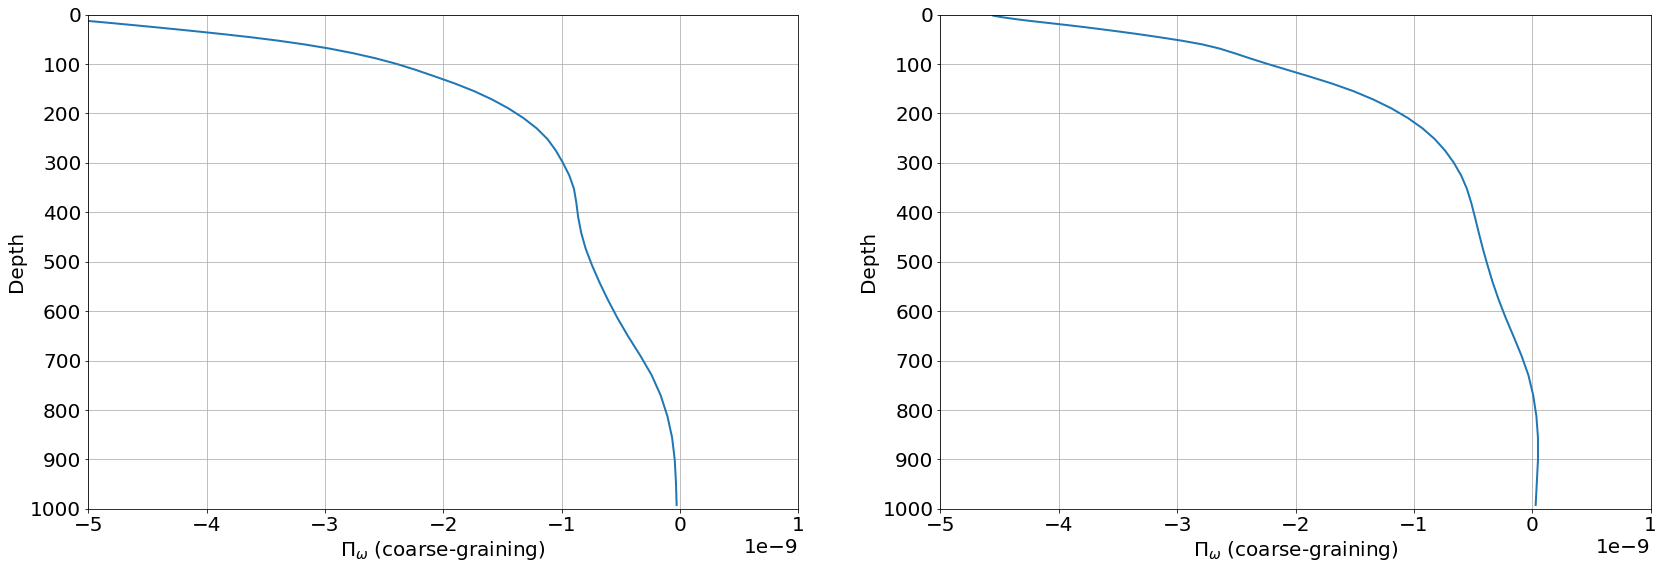

In [33]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
(ds.PI_cg_5d-ds.PI_cg_1d).isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-12-01T23:00:00','2012-03-01T23:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

ax = plt.subplot(222)
(ds.PI_cg_5d-ds.PI_cg_1d).isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-03-01T23:00:00','2012-06-01T23:00:00')).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


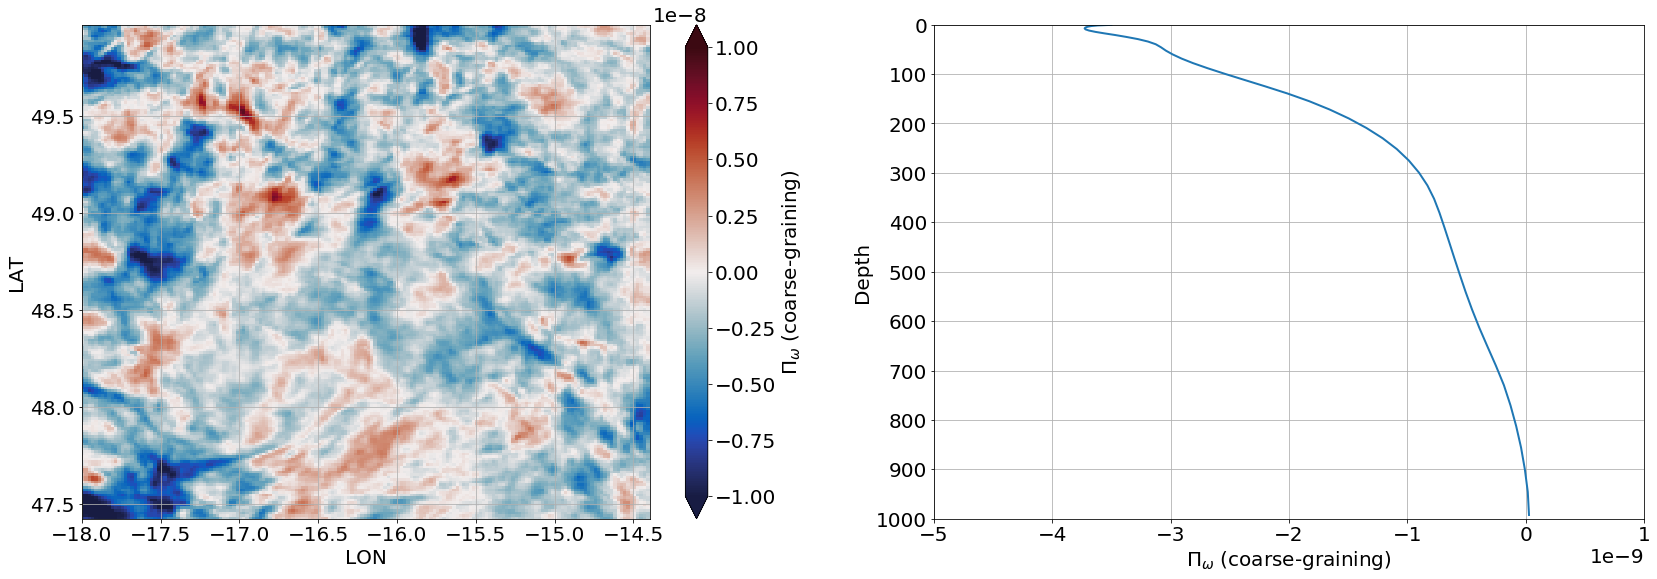

In [26]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = (PI_cg_5d-PI_cg_1d).isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50),time=slice(10,8761)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
(PI_cg_5d-PI_cg_1d).isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,8761)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


[Text(0, 0, '11-11'),
 Text(0, 0, '11-12'),
 Text(0, 0, '12-01'),
 Text(0, 0, '12-02'),
 Text(0, 0, '12-03'),
 Text(0, 0, '12-04'),
 Text(0, 0, '12-05'),
 Text(0, 0, '12-06'),
 Text(0, 0, '12-07'),
 Text(0, 0, '12-08'),
 Text(0, 0, '12-09')]

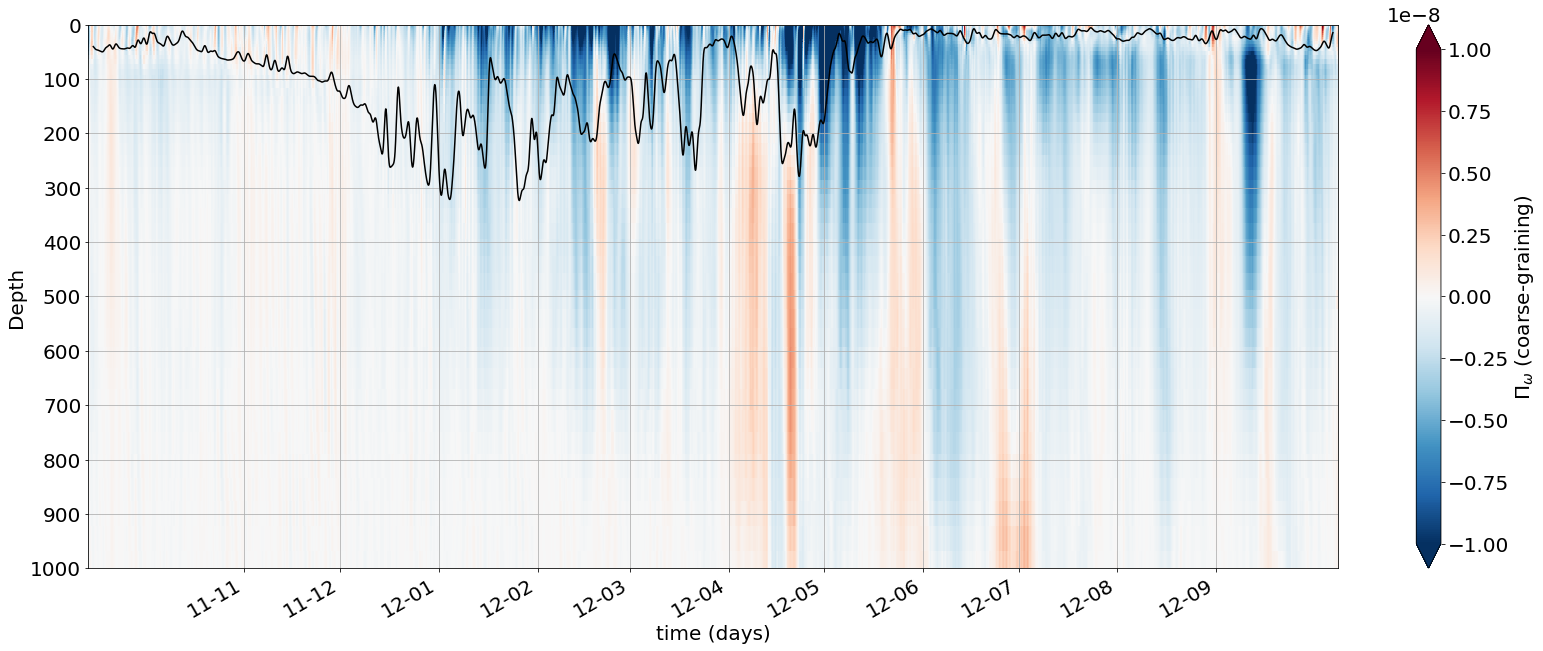

In [38]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = (ds.PI_cg_5d-ds.PI_cg_1d).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000, 900,800,700,600,500,400,300,200,100,0.])
ax.set_xticks(['2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['11-10','11-11', '11-12', '12-01', '12-02', '12-03', '12-04', '12-05', '12-06', '12-07', '12-08', '12-09'])

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together2_coarse_graining.png')

In [41]:
PI_cg_cumsum = 3600*(ds.PI_cg_5d-ds.PI_cg_1d).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).cumsum(['time'])
PI_cg_cumsum.persist()

<xarray.DataArray (depth: 52, time: 9415)>
dask.array<mul, shape=(52, 9415), dtype=float32, chunksize=(1, 9415), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

[Text(0, 0, '11-10'),
 Text(0, 0, '11-11'),
 Text(0, 0, '11-12'),
 Text(0, 0, '12-01'),
 Text(0, 0, '12-02'),
 Text(0, 0, '12-03'),
 Text(0, 0, '12-04'),
 Text(0, 0, '12-05'),
 Text(0, 0, '12-06'),
 Text(0, 0, '12-07'),
 Text(0, 0, '12-08'),
 Text(0, 0, '12-09')]

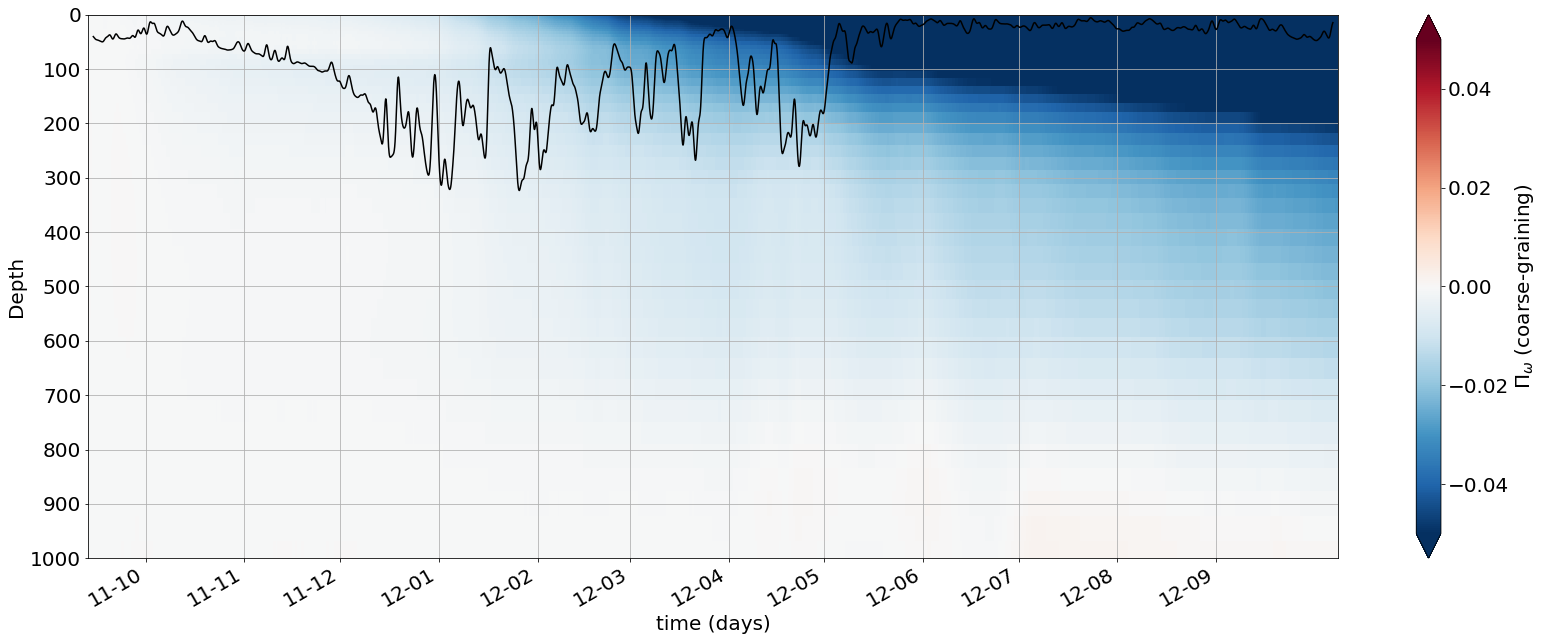

In [44]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = PI_cg_cumsum.plot(x='time', y='depth',cmap='RdBu_r',vmin=-0.05,vmax=0.05,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000, 900,800,700,600,500,400,300,200,100,0.])
ax.set_xticks(['2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['11-10','11-11', '11-12', '12-01', '12-02', '12-03', '12-04', '12-05', '12-06', '12-07', '12-08', '12-09'])

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together2_coarse_graining.png')

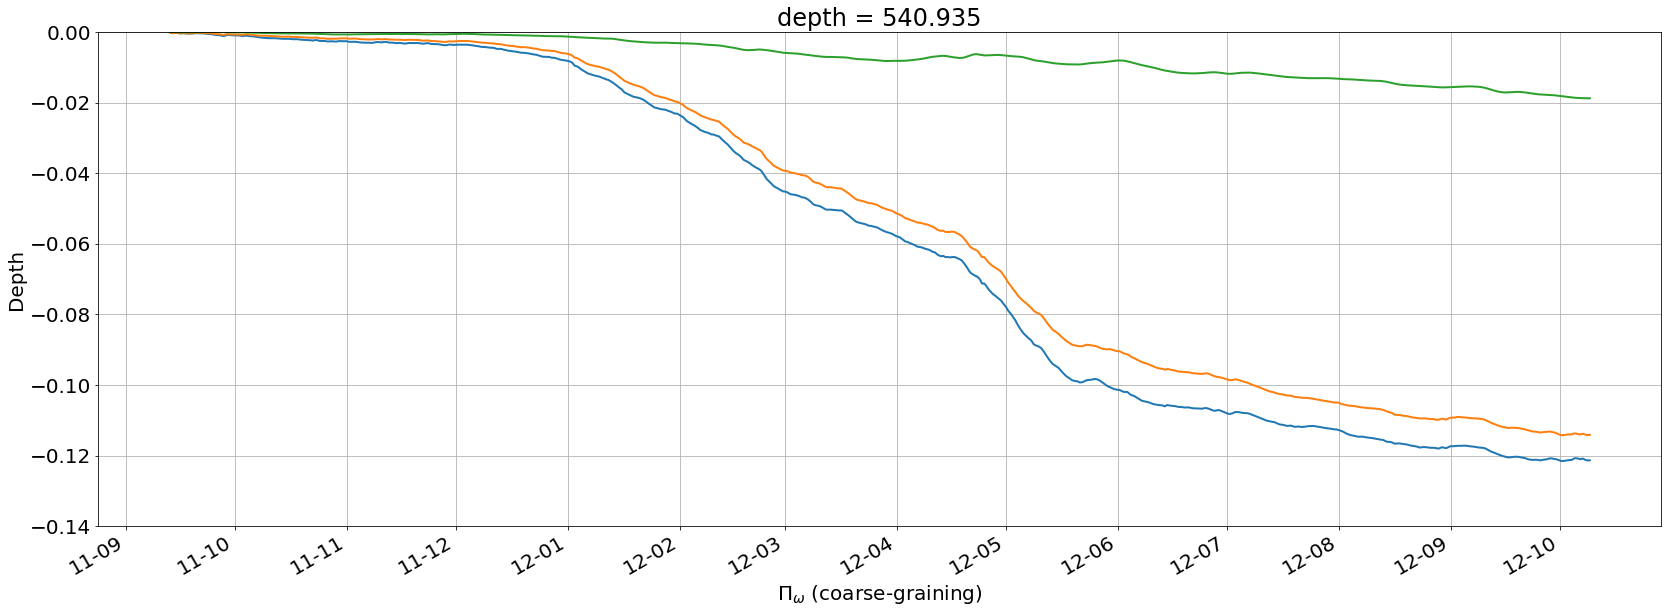

In [48]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(211)
PI_cg_cumsum.isel(depth=5).plot(x='time', linewidth=2)
PI_cg_cumsum.isel(depth=10).plot(x='time', linewidth=2)
PI_cg_cumsum.isel(depth=40).plot(x='time', linewidth=2)

ax.grid()
ax.set_ylim([-0.14, 0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10'])
ax.set_xticklabels(['11-09','11-10','11-11', '11-12', '12-01', '12-02', '12-03', '12-04', '12-05', '12-06', '12-07', '12-08', '12-09', '12-10'])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
#ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

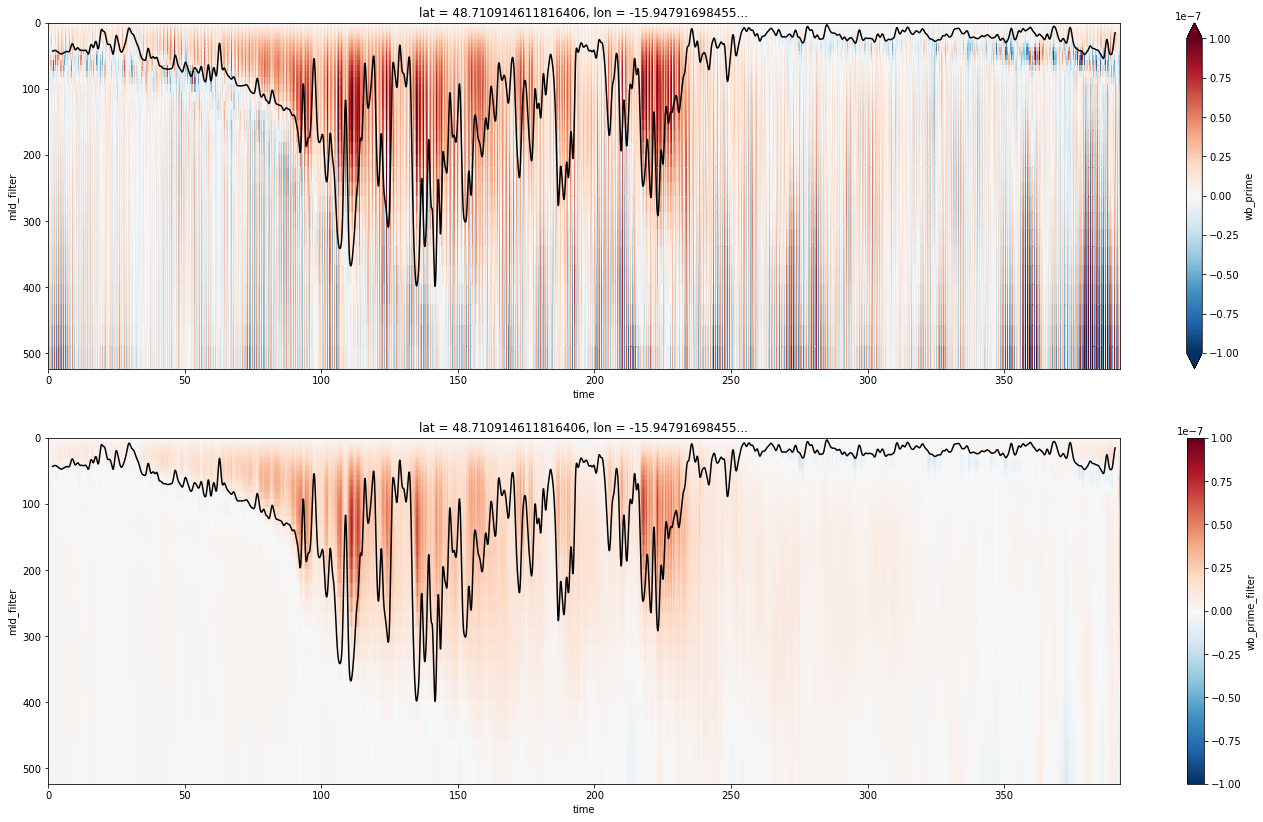

In [26]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
wb_prime.wb_prime.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
wb_prime_filter.wb_prime_filter.isel(depth=slice(0,40)).plot(x='time', y='depth',vmin=-1e-7,vmax=1e-7,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

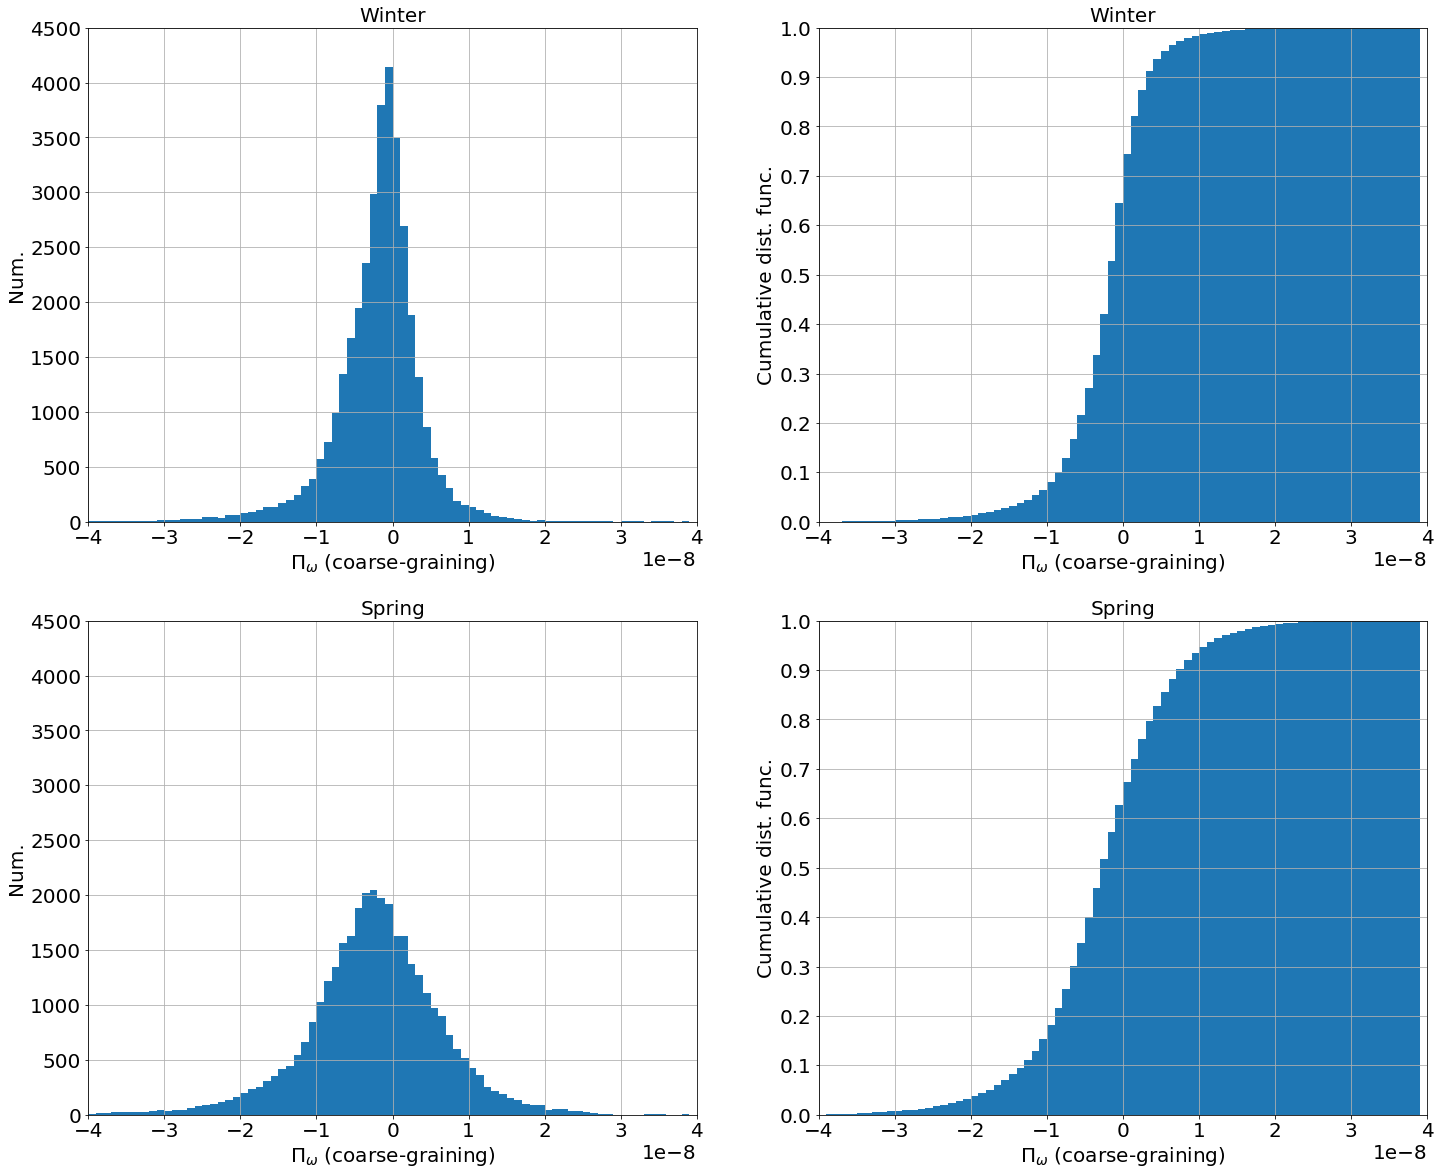

In [21]:
font_size = 20

fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(221)
(PI_cg_5-PI_cg_1).isel(time=slice(2000,4000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9))
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,4500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.set_title('Winter',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
(PI_cg_5-PI_cg_1).isel(time=slice(2000,4000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_title('Winter',fontsize=font_size)
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
(PI_cg_5-PI_cg_1).isel(time=slice(4000,6000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9))
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,4500])
ax.set_ylabel('Num.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
(PI_cg_5-PI_cg_1).isel(time=slice(4000,6000),depth=slice(15,40)).mean(['time','depth']).plot.hist(bins=np.arange(-4e-8,4e-8,1e-9),density=True,cumulative=True)
ax.grid()
ax.set_xlim([-4e-8,4e-8])
ax.set_ylim([0.,1])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.set_title('Spring',fontsize=font_size)
ax.tick_params(labelsize=font_size)

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_histogram_coarse_graining.png')

___________
# Long periods

In [6]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/gaussian/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_30 = xr.concat(D, dim='depth')
PI_cg_30 = PI_cg_30.PI_cg_single
PI_cg_30

<xarray.DataArray 'PI_cg_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [7]:
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/gaussian/'
D = [xr.open_zarr(out_dir_store+'PI_cg_90_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_90 = xr.concat(D, dim='depth')
PI_cg_90 = PI_cg_90.PI_cg_single
PI_cg_90

<xarray.DataArray 'PI_cg_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

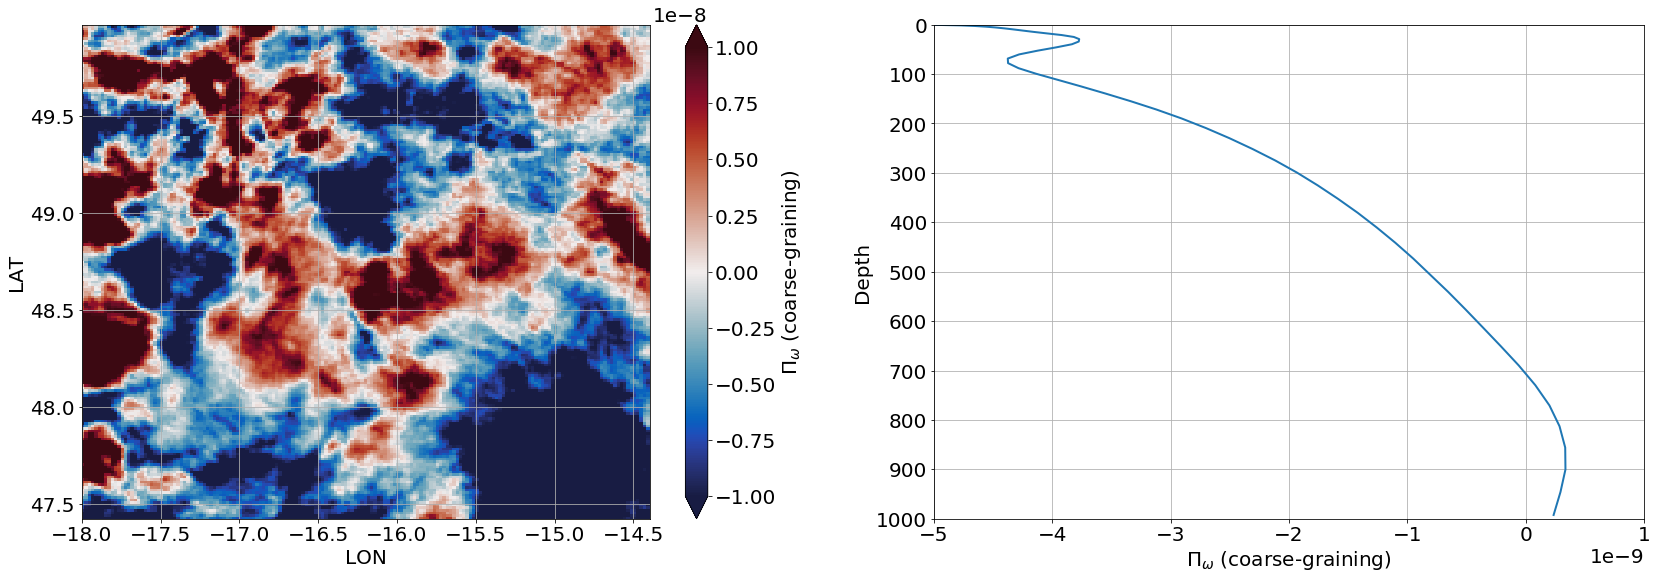

In [8]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = PI_cg_90.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
PI_cg_90.isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


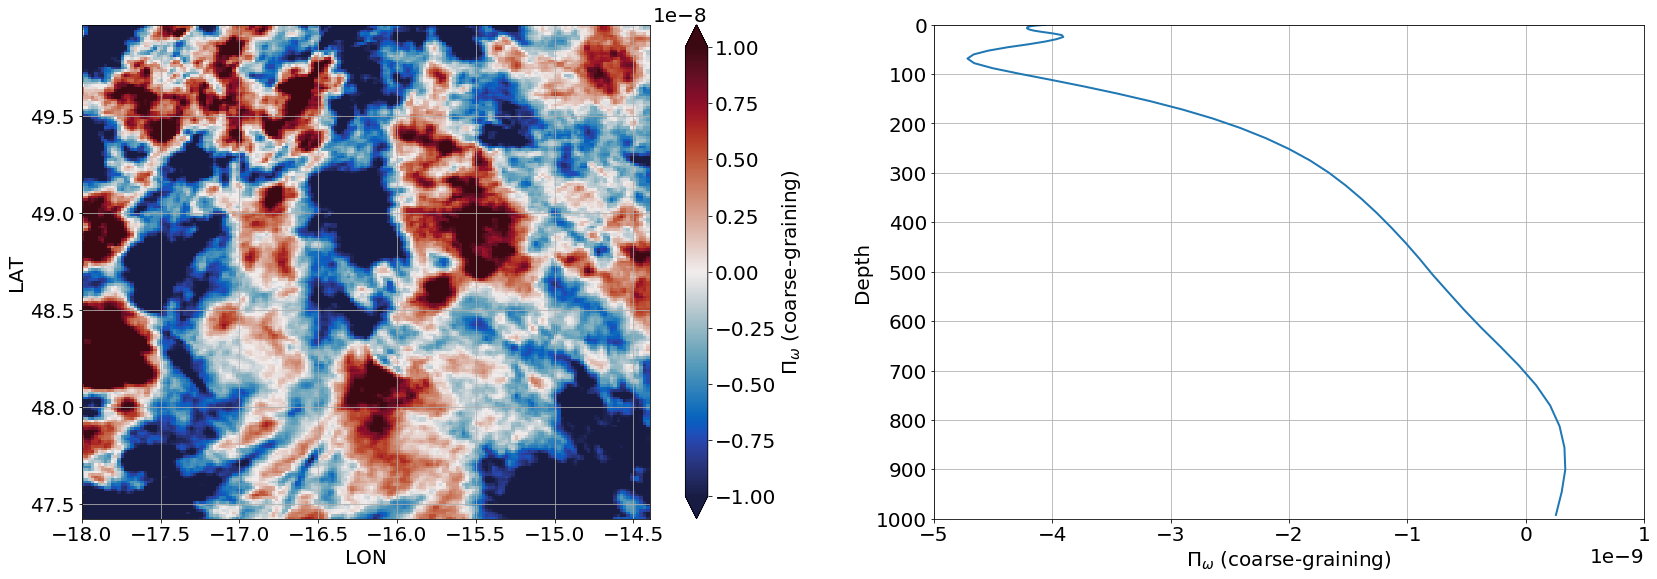

In [16]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = PI_cg_30.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
PI_cg_30.isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


In [9]:
out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

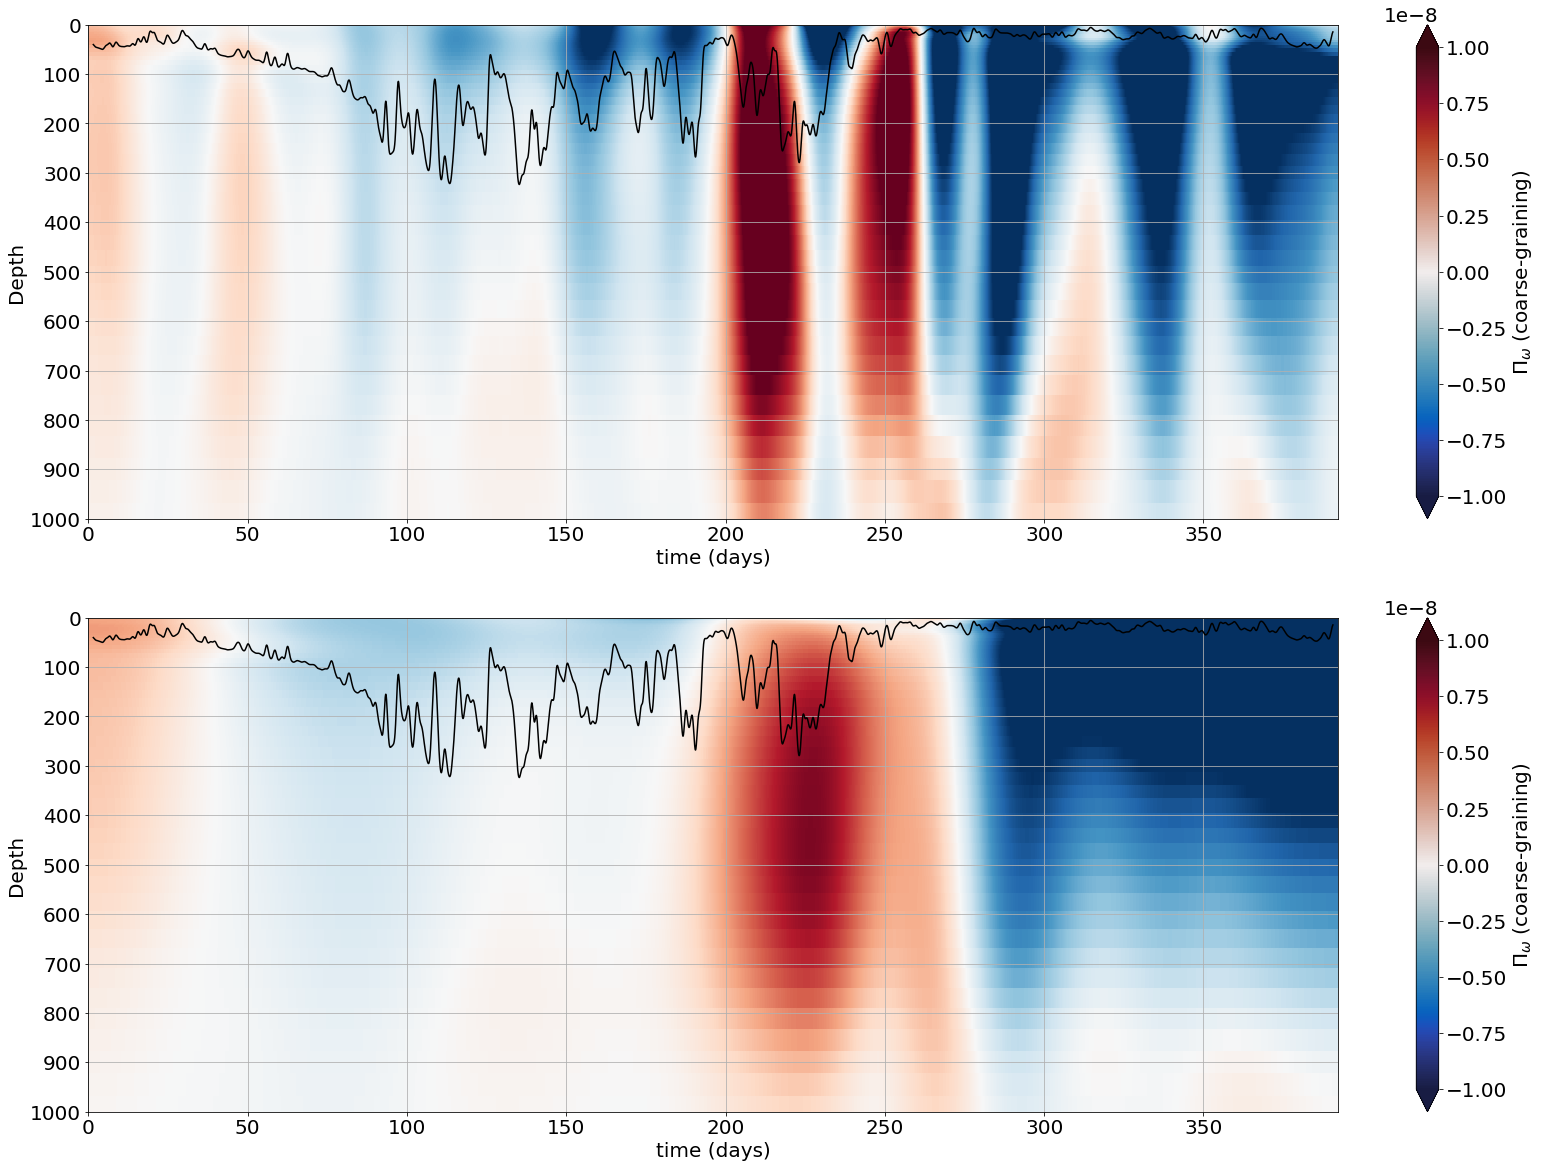

In [10]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,20))

ax = plt.subplot(211)
cbar = (PI_cg_30).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])

ax = plt.subplot(212)
cbar = (PI_cg_90).isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([1000., 0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


In [1]:
cluster.close()

NameError: name 'cluster' is not defined